# Plots and Figures of the CSNN Paper

In [2]:
%matplotlib inline

In [3]:
# Set this directory to the folder containing the experiment results of the CSNN implementation.
# This path is used to get data of the trained models.
DATA_PATH="/home/bonifaz/Dokumente/experiments/Paper"

### Imports

In [4]:
import glob
import cv2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from tensorboard.backend.event_processing import event_accumulator

## Define functions to load the data

In [5]:
def loadTensorboardScalarData(enty_tag, folder_path):
    """
    Loads the scalar data of the log entry with the given entry tag from the given path.
    :param enty_tag: (String) The tag of the entry from which to get the data.
    :param folder_path: (String) The path to the log.
    :return: data_per_step: (Tupel) (step_nums, data) The data for each step.
    """
    ea = event_accumulator.EventAccumulator(folder_path, size_guidance={'scalars': 0})
    ea.Reload()
    _, step_nums, data = zip(*ea.Scalars(enty_tag))
    return (step_nums,data)

def loadTensorboardImageData(enty_tag, folder_path):
    """
    Loads the scalar data of the log entry with the given entry tag from the given path.
    :param enty_tag: (String) The tag of the entry from which to get the data.
    :param folder_path: (String) The path to the log.
    :return: data_per_step: (ImageEvent) The entry images.
    """
    ea = event_accumulator.EventAccumulator(folder_path, size_guidance={'images': 0})
    ea.Reload()
    imgs = ea.Images(enty_tag)
    return imgs

In [6]:
def loadAccuraciesFromTextForOfmPlot(path, model_names, dataset_names):
    """
    Loads the test accuracies of the given models trained on the given datasets from the speciefied path 
    for Fig. 4 of the paper.
    :param path: (String) The path from which to get the test accuracies.
    :param model_names: (List) The names of the models for which to get the test accuracies.
    :param dataset_names: List) The names of the datasasetsfor which to get the test accuracies.
    :return: data: (Dictionary) {"Dataset1":{"Model1":(ofm_step, acc),"Model2": ...} ...} 
                   The accuracies for each dataset and model and ofmstep
    """
    data = {}
    for model_name in model_names:
        for dataset in dataset_names:
            dir_path = path + "/" + model_name + "/" + dataset + "/xFoldCrossVal0"
            text_files = glob.glob(dir_path+'/nonlinearClassifier*/txtlogs/test.txt', recursive=True) 
            if not text_files:
                continue
            if dataset not in data.keys():
                data[dataset]={}
            data[dataset][model_name]=[[], []]
            for file in text_files:
                with open(file) as f:
                    content = f.readlines()
                    acc = float(content[2].split(":")[1].strip())
                    step = int(''.join(filter(str.isdigit, file.split("/xFoldCrossVal0")[1])))
                    data[dataset][model_name][0].append(step)
                    data[dataset][model_name][1].append(acc)
            sort_index=np.argsort(np.array(data[dataset][model_name][0]))
            data[dataset][model_name][0] = np.array(data[dataset][model_name][0])[sort_index]
            data[dataset][model_name][1] = np.array(data[dataset][model_name][1])[sort_index]

            argmaxacc=np.argmax(data[dataset][model_name][1])
            print(model_name+" "+dataset 
                  +" Max acc:" + str(data[dataset][model_name][1][argmaxacc]) + " at step:" 
                  + str(data[dataset][model_name][0][argmaxacc]))
    return data

In [7]:
def loadTableAccuraciesFromText(path, model_names, dataset_names, classifier_names):
    """
    Loads the test accuracies of the given models trained on the given datasets for the given classifier names
    from the speciefied path. Used to fill the Tables in the Paper
    :param path: (String) The path from which to get the accuracies.
    :param model_names: (List) The names of the models for which to get the test accuracies.
    :param dataset_names: List) The names of the datasasetsfor which to get the test accuracies.
    :return: data: (Dictionary) {"Dataset1":{"Model1":[acc_steptest1, acc_steptest2 ...],"Model2": ...} ...} 
                   The accuracies of the classifier for each dataset and model and test.
    """
    data = {}
    for model_name in model_names:
        for dataset in dataset_names:
              for classifier in classifier_names:
                dir_path = path + "/" + model_name + "/" + dataset
                text_files = glob.glob(dir_path+"/xFoldCrossVal*/"+classifier+"/txtlogs/test.txt", 
                                       recursive=True)         
                if not text_files:
                    continue
                if dataset not in data.keys():
                    data[dataset]={}
                if model_name not in data[dataset].keys():
                    data[dataset][model_name]={}
                data[dataset][model_name][classifier]=[]
                for file in text_files:
                    with open(file) as f:
                        content = f.readlines()
                        acc = float(content[2].split(":")[1].strip())
                        data[dataset][model_name][classifier].append(acc)

                maxacc=np.max(data[dataset][model_name][classifier])
                minacc=np.min(data[dataset][model_name][classifier])
                meanacc=np.mean(data[dataset][model_name][classifier])
                print(model_name+" "+dataset+ " "+ classifier +
                      " Max acc:" + str(np.around(maxacc, 2)) + 
                      " Min acc:" + str(np.around(minacc, 2)) + 
                      " Mean acc:" + str(np.around(meanacc, 2))  + 
                      " + acc:" + str(np.around((maxacc-meanacc), 2)) + 
                      " - acc:" + str(np.around((minacc-meanacc), 2)))
    return data

In [8]:
def saveAndShow2DImagePlot(i_tags, y_label, step_indices, path, save_name):
    """
    Saves and shows a 2d image plot of the images given in the entry tags.
    :param i_tags: (List) The entry tags of the images to load from the log.
    :param y_label: (String) The names of the y-axis.
    :param step_indices: (List) The indices of the steps to show the image for.
    :param path: (String) The path to save the plot.
    :param data_steps: (List) The step_indices of the images to show and save.
    :param save_name: (String) The name of the saved file.
    """
    loaded_data = []
    for i_tag in i_tags:
        loaded_data.append(loadTensorboardImageData(i_tag, path))

    data = []
    for tag_data in loaded_data:
        new_tag_data = []
        for i in step_indices:
            new_tag_data.append(tag_data[i])
        data.append(new_tag_data)
    
    height = len(data)
    width = len(data[0])
    with plt.style.context('seaborn'):
        fig, axs = plt.subplots(height, width, figsize=(2.5*width, 2.5*height))
        for h in range(0, height):
            i=0
            for w in range(0, width):
                ax = axs[h,w]
                
                image = np.frombuffer(data[h][w].encoded_image_string, np.uint8)
                image = cv2.imdecode(image, cv2.IMREAD_COLOR)
                
                if h is 0:
                    ax.set_title("Step " + str(data[h][w].step))
                if w is 0:
                    ax.set_ylabel(y_label + str(h+ 1))
                ax.grid(False)
                ax.set_yticklabels([])
                ax.set_xticklabels([])
                ax.imshow(image)
                i+=1
                
        plt.subplots_adjust(wspace=0.002, hspace=0.05)        
        plt.savefig(save_name)
        plt.show()

In [9]:
def saveAndShow2DImagePlotPerMap(i_tags, step_indices, num_layers, path, save_name):
    """
    Saves and shows a 2d image plot of the images given in the entry tags for each map.
    :param i_tags: (List) The entry tags of the images to load from the log.
    :param step_indices: (List) The indices of the steps to show the image for.
    :param path: (String) The path to save the plot.
    :param data_steps: (List) The step_indices of the images to show and save.
    :param save_name: (String) The name of the saved file.
    """
    # Load the data
    loaded_data = []
    for i_tag in i_tags:
        loaded_data.append(loadTensorboardImageData(i_tag, path))

    # Take ~a third of the data
    data = []
    for tag_data in loaded_data:
        new_tag_data = []
        for i in step_indices:
            new_tag_data.append(tag_data[i])
        data.append(new_tag_data)

    # Create, show and save plot
    height = len(data)
    width = len(data[0])
    with plt.style.context('seaborn'):
        fig, axs = plt.subplots(height, width, figsize=(1.75*width, 1.75*height))
        for h in range(0, height):
            i=0
            for w in range(0, width):
                ax = axs[h,w]
                image = np.frombuffer(data[h][w].encoded_image_string, np.uint8)
                image = cv2.imdecode(image, cv2.IMREAD_COLOR)
                if h is 0:
                    ax.set_title("Step " + str(data[h][w].step))
                if w is 0:
                    ax.set_ylabel("Layer " + str(int(h/num_layers)+1) + " | SOM " + str(h%num_layers+1))
                ax.grid(False)
                ax.set_yticklabels([])
                ax.set_xticklabels([])
                im=ax.imshow(image)
                i+=1
        plt.subplots_adjust(wspace=0.002, hspace=0.05)
        plt.savefig(save_name)
        plt.show()

In [10]:
def plotTrainingCurves(data, y_label, save_name):
    """
    Plots simple training curves like losses or accuracies for the given data.
    :param y_label: (String) The label of the y-axis.
    :param data: (Dcitionary) {key1:(steps,values), key2:(steps,values), ...}
    :param save_name: (String) The name of the saved file.
    """
    # Remove validation for best checkpoint value.
    for key in data.keys():  
        key_data = data[key]
        key_data1 = key_data[0][0:-1]
        key_data2 = key_data[1][0:-1]
        data[key] = (key_data1, key_data2)

    # Set plot styles and color
    linestyles = {"nl-train":'-.', "nl-eval":'-', 
                  "l-train":':', "l-eval":'--'}

    colors = {"nl-train":'#bf6c8e', "nl-eval":'#a67383', "l-train":'#6c8fbf', "l-eval":'#A9C4EB'}

    with plt.style.context('seaborn-whitegrid'):
        for name, values in data.items():
            plt.plot(values[0], values[1], color=colors[name], linestyle=linestyles[name], label=name)

    # Create, show and save plot
    leg = plt.legend(ncol=1, loc=1)
    plt.ylabel(y_label)
    plt.xlabel('Training Steps')
    plt.grid(True)  
    plt.savefig(save_name)
    plt.show()

## Objective Function Mismatch: Figure 4 of the Paper

S2-CSNN-B1 Cifar10 Max acc:72.62037992477417 at step:750
S2-CSNN-B1 Cifar100 Max acc:45.93351483345032 at step:3000
S2-CSNN-B32 Cifar10 Max acc:73.40003252029419 at step:4000
S2-CSNN-B32 Cifar100 Max acc:44.890785217285156 at step:250
S-CSNN-B1 Cifar10 Max acc:72.82007336616516 at step:250
S-CSNN-B1 Cifar100 Max acc:45.18853724002838 at step:1000
S-CSNN-B32 Cifar10 Max acc:72.93726205825806 at step:500
S-CSNN-B32 Cifar100 Max acc:45.483893156051636 at step:500
S-CSNN-B128 Cifar10 Max acc:73.16446304321289 at step:500
S-CSNN-B128 Cifar100 Max acc:45.644932985305786 at step:500
D-CSNN-B1 Cifar10 Max acc:77.36169099807739 at step:2000
D-CSNN-B1 Cifar100 Max acc:49.65322017669678 at step:1000
D-CSNN-B4 Cifar10 Max acc:76.94236040115356 at step:4000
D-CSNN-B4 Cifar100 Max acc:49.54320788383484 at step:3000
D2-CSNN-B1 Cifar10 Max acc:75.86416006088257 at step:16000
D2-CSNN-B1 Cifar100 Max acc:48.67665767669678 at step:20000


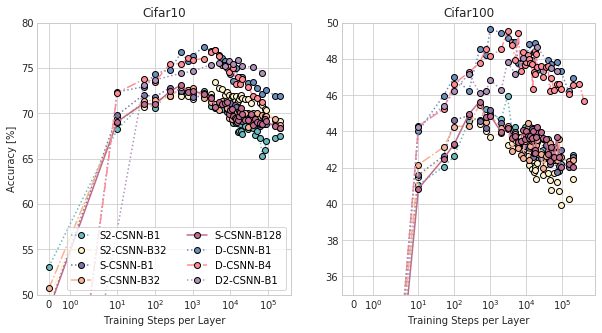

In [11]:
# Path to data
OFM_MODELS_DATA_PATH = DATA_PATH + "/Ofm"

# Load the data
data = loadAccuraciesFromTextForOfmPlot(OFM_MODELS_DATA_PATH, 
                              model_names=["S2-CSNN-B1", "S2-CSNN-B32", "S2-CSNN-B128", 
                                           "S-CSNN-B1", "S-CSNN-B32", "S-CSNN-B128",
                                           "D-CSNN-B1", "D-CSNN-B4", "D2-CSNN-B1"],
                              dataset_names=["Cifar10", "Cifar100"])

# Set plot styles and color
linestyles = {"S-CSNN-B1":':',  "S-CSNN-B32":'-.', "S-CSNN-B128":'-',
              "S2-CSNN-B1":':', "S2-CSNN-B32":'-.', "S2-CSNN-B128":'-', 
              "D-CSNN-B1":':', "D-CSNN-B4":'-.', 
              "D2-CSNN-B1":':',}

colors= {"S-CSNN-B1":'#7d73a6', "S-CSNN-B32":'#F8B195', "S-CSNN-B128":'#bf6c8e', 
         "S2-CSNN-B1":'#6cb8bf', "S2-CSNN-B32":'#FFF2CC', "S2-CSNN-B128":'#8fbf6c',
         "D-CSNN-B1":'#6C8EBF', "D-CSNN-B4":'#FF8C94',
         "D2-CSNN-B1":'#ad92ba'}

# Create, show and save plot
with plt.style.context('seaborn-whitegrid'):
    i=0  
    fig, axs = plt.subplots(ncols=2, nrows=1,  figsize=(10,5))
    for key, dataset in data.items():
        ax = axs[i]
        for name, model_acc in dataset.items():
            ax.plot(model_acc[0], model_acc[1], color=colors[name], linestyle=linestyles[name], 
                    markeredgecolor='black', label=name, marker='o')
        ax.set_title(key)
        if i == 0:
            ax.set_ylabel('Accuracy [%]')
        ax.set_xlabel('Training Steps per Layer')
        ax.grid(True)
        ax.set_xscale("symlog")
        if i is 0:
            ax.set_ylim(ymin=50, ymax=80)
        else:
            ax.set_ylim(ymin=35, ymax=50)
        i+=1
        
leg = axs[0].legend(ncol =2)
plt.savefig("ofm.pdf")
plt.show()

## Neuron Utilizations and few-shot Classifier Accuracy of D-CSNN: Figure 5 of the Paper  

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest even

D-CSNN-B1-10Fold Cifar10 fewShotClassifier1Shot Max acc:20.89 Min acc:12.46 Mean acc:17.56 + acc:3.33 - acc:-5.1
D-CSNN-B1-10Fold Cifar10 fewShotClassifier6Shot Max acc:27.69 Min acc:23.33 Mean acc:25.65 + acc:2.04 - acc:-2.32
D-CSNN-B1-10Fold Cifar10 fewShotClassifier11Shot Max acc:31.57 Min acc:27.19 Mean acc:29.41 + acc:2.16 - acc:-2.22
D-CSNN-B1-10Fold Cifar10 fewShotClassifier16Shot Max acc:35.0 Min acc:30.81 Mean acc:32.8 + acc:2.2 - acc:-1.99
D-CSNN-B1-10Fold Cifar10 fewShotClassifier21Shot Max acc:36.64 Min acc:33.22 Mean acc:35.18 + acc:1.46 - acc:-1.95
D-CSNN-B1-10Fold Cifar10 fewShotClassifier26Shot Max acc:39.14 Min acc:35.71 Mean acc:37.25 + acc:1.88 - acc:-1.54
D-CSNN-B1-10Fold Cifar10 fewShotClassifier31Shot Max acc:41.15 Min acc:37.83 Mean acc:39.23 + acc:1.92 - acc:-1.39
D-CSNN-B1-10Fold Cifar10 fewShotClassifier36Shot Max acc:43.03 Min acc:38.2 Mean acc:40.64 + acc:2.39 - acc:-2.45
D-CSNN-B1-10Fold Cifar10 fewShotClassifier41Shot Max acc:44.13 Min acc:39.89 Mean acc:4

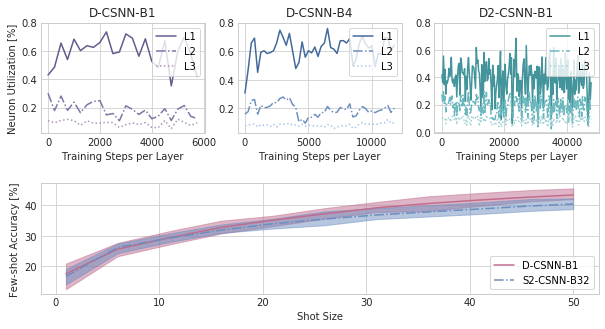

In [12]:
# Paths to data for neuron_utilizations
DCSNNB1_PATH=DATA_PATH+"/MethodInfluences2/D-CSNN-B1/Cifar10/xFoldCrossVal0/Csnn/logs/train"
DCSNNB4_PATH=DATA_PATH+"/MethodInfluences2/D-CSNN-B4/Cifar10/xFoldCrossVal0/Csnn/logs/train"
D2CSNNB1_PATH=DATA_PATH+"/MethodInfluences2/D2-CSNN-B1/Cifar10/xFoldCrossVal0/Csnn/logs/train"

# Paths to data for few-shot accuracies
S2CSNNB32_10FOLD_PATH=DATA_PATH+"/FewShot/S2-CSNN-B32-10Fold/Cifar10/xFoldCrossVal0/Csnn/logs/train"
DCSNNB1_10FOLD_PATH=DATA_PATH+"/MethodInfluences2/D-CSNN-B1-10Fold/Cifar10/xFoldCrossVal0/Csnn/logs/train"

# Log tags
neuron_utilization_tag="Training/OptimizeCsnn/OptimizeSomWeights/NeuronUtilization"
fewshot_tag="Training/OptimizeCsnn/OptimizeSomWeights/MeanWeightChangeLayer"

# Multi GPU log tags
neuron_utilization_tag1="applyLearningWeights/OptimizeCsnn/OptimizeSomWeights/NeuronUtilization"

# Few-Shot Classifier names.
fewShotClassifierSteps=[i for i in range(1, 50, 5)]
fewShotClassifierSteps.append(50)

fewShotClassifiers=[]
for i in range(0, len(fewShotClassifierSteps)):
    fewShotClassifiers.append("fewShotClassifier"+str(fewShotClassifierSteps[i])+"Shot")
    
# Load the data
neuron_utilization_data = [
    {"D-CSNN-B1L1":loadTensorboardScalarData(neuron_utilization_tag+"0", DCSNNB1_PATH), 
     "D-CSNN-B1L2":loadTensorboardScalarData(neuron_utilization_tag+"1", DCSNNB1_PATH), 
     "D-CSNN-B1L3":loadTensorboardScalarData(neuron_utilization_tag+"2", DCSNNB1_PATH)},
    {"D-CSNN-B4L1":loadTensorboardScalarData(neuron_utilization_tag1+"0", DCSNNB4_PATH), 
     "D-CSNN-B4L2":loadTensorboardScalarData(neuron_utilization_tag1+"1", DCSNNB4_PATH),
     "D-CSNN-B4L3":loadTensorboardScalarData(neuron_utilization_tag1+"2", DCSNNB4_PATH)}, 
    {"D2-CSNN-B1L1":loadTensorboardScalarData(neuron_utilization_tag+"0", D2CSNNB1_PATH),
     "D2-CSNN-B1L2":loadTensorboardScalarData(neuron_utilization_tag+"1", D2CSNNB1_PATH), 
     "D2-CSNN-B1L3":loadTensorboardScalarData(neuron_utilization_tag+"2", D2CSNNB1_PATH)}]
    
fewshot_data = { "D-CSNN-B1":loadTableAccuraciesFromText(DATA_PATH+"/FewShot", ["D-CSNN-B1-10Fold"], 
                                                          ["Cifar10"], fewShotClassifiers),
                 "S2-CSNN-B32":loadTableAccuraciesFromText(DATA_PATH+"/FewShot", ["S2-CSNN-B32-10Fold"], 
                                                          ["Cifar10"], fewShotClassifiers)} 

# Set plot styles and color
neuron_utilization_linestyles = {
    "D-CSNN-B1L1":'-', "D-CSNN-B1L2":'-.', "D-CSNN-B1L3":':', 
    "D-CSNN-B4L1":'-', "D-CSNN-B4L2":'-.', "D-CSNN-B4L3":':',
    "D2-CSNN-B1L1":'-', "D2-CSNN-B1L2":'-.',"D2-CSNN-B1L3":':'}
neuron_utilization_colors= {
    "D-CSNN-B1L1":'#63598d', "D-CSNN-B1L2":'#7d73a6', "D-CSNN-B1L3":'#ad92ba', 
    "D-CSNN-B4L1":'#43689b', "D-CSNN-B4L2":'#6c8fbf',"D-CSNN-B4L3":'#A9C4EB', 
    "D2-CSNN-B1L1":'#43959b',"D2-CSNN-B1L2":'#6cb8bf', "D2-CSNN-B1L3":'#a1d2d6'}

fewshot_colors= {
    "S2-CSNN-B32":'#6C8EBF', "D-CSNN-B1":'#bf6c8e'}
fewshot_tag_linestyles = {
    "S2-CSNN-B32":'-.', "D-CSNN-B1":'-'}

# Create, show and save plot
with plt.style.context('seaborn-whitegrid'):
    fig = plt.figure(figsize=(10,5))
    axs = []
    for i in range(0, 3):
        ax=fig.add_subplot(2, 3, i+1)
        for name, layer in neuron_utilization_data[i].items():
            ax.plot(layer[0], layer[1], color=neuron_utilization_colors[name], 
                    linestyle=neuron_utilization_linestyles[name], label=name[-2:])  
        if i is 0:
            ax.set_ylabel('Neuron Utilization [%]')
        ax.set_xlabel('Training Steps per Layer')
        ax.grid(True)
        ax.set_title(name[0:-2])
        ax.set_ylim(ymax=0.8)
        axs.append(ax)
        
    ax = fig.add_subplot(2, 1, 2)
    for name, csnn in fewshot_data.items():
        for step, few_shot_step_accs in csnn["Cifar10"].items():
            mean_accs = np.mean(list(few_shot_step_accs.values()), axis=1)
            min_accs = np.min(list(few_shot_step_accs.values()), axis=1)
            max_accs = np.max(list(few_shot_step_accs.values()), axis=1)
            ax.plot(fewShotClassifierSteps, mean_accs, color=fewshot_colors[name], 
            linestyle=fewshot_tag_linestyles[name], label=name)
            ax.fill_between(fewShotClassifierSteps, min_accs, max_accs, color=fewshot_colors[name], alpha=0.5)
    ax.set_ylabel('Few-shot Accuracy [%]')
    ax.set_xlabel('Shot Size')
    ax.grid(True)
      
leg = axs[0].legend(ncol=1, loc=1)
leg = axs[1].legend(ncol=1, loc=1)
leg = axs[2].legend(ncol=1, loc=1)
leg = ax.legend(ncol=1, loc=4)
fig.subplots_adjust(hspace=0.45)
fig.savefig("utilAndFs.pdf")
plt.show()

## Mean SOM and Mask Weight Changes: Figure 8 of the Appendix from the Paper

Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one metagr

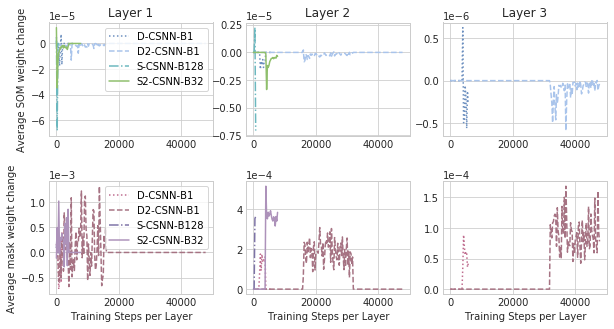

In [13]:
# Paths to data
DCSNNB1_PATH=DATA_PATH+"/MethodInfluences2/D-CSNN-B1/Cifar10/xFoldCrossVal0/Csnn/logs/train"
D2CSNNB1_PATH=DATA_PATH+"/MethodInfluences2/D2-CSNN-B1/Cifar10/xFoldCrossVal0/Csnn/logs/train"
SCSNNB128_PATH=DATA_PATH+"/MethodInfluences2/S-CSNN-B128/Cifar10/xFoldCrossVal0/Csnn/logs/train"
S2CSNNB32_PATH=DATA_PATH+"/MethodInfluences2/S2-CSNN-B32/Cifar10/xFoldCrossVal0/Csnn/logs/train"

# Log tags
som_mean_weight_change_tag="Training/OptimizeCsnn/OptimizeLocalWeights/MeanLocalWeightChangeLayer"
mask_mean_weight_change_tag="Training/OptimizeCsnn/OptimizeSomWeights/MeanWeightChangeLayer"
som_mean_weight_change_tag2="applyLearningWeights/OptimizeCsnn/OptimizeLocalWeights/MeanLocalWeightChangeLayer"
mask_mean_weight_change_tag2="applyLearningWeights/OptimizeCsnn/OptimizeSomWeights/MeanWeightChangeLayer"

# Load the data
som_mean_weight_data = {
         "D-CSNN-B1":[loadTensorboardScalarData(som_mean_weight_change_tag+"0", DCSNNB1_PATH),
                      loadTensorboardScalarData(som_mean_weight_change_tag+"1", DCSNNB1_PATH),
                      loadTensorboardScalarData(som_mean_weight_change_tag+"2", DCSNNB1_PATH)],
         "D2-CSNN-B1":[loadTensorboardScalarData(som_mean_weight_change_tag+"0", D2CSNNB1_PATH),
                       loadTensorboardScalarData(som_mean_weight_change_tag+"1", D2CSNNB1_PATH),
                       loadTensorboardScalarData(som_mean_weight_change_tag+"2", D2CSNNB1_PATH)],
         "S-CSNN-B128":[loadTensorboardScalarData(som_mean_weight_change_tag2+"0", SCSNNB128_PATH), 
                       loadTensorboardScalarData(som_mean_weight_change_tag2+"1", SCSNNB128_PATH)],
         "S2-CSNN-B32":[loadTensorboardScalarData(som_mean_weight_change_tag2+"0", S2CSNNB32_PATH), 
                        loadTensorboardScalarData(som_mean_weight_change_tag2+"1", S2CSNNB32_PATH)]}

mask_mean_weight_change_data = {
          "D-CSNN-B1":[loadTensorboardScalarData(mask_mean_weight_change_tag+"0", DCSNNB1_PATH),
                       loadTensorboardScalarData(mask_mean_weight_change_tag+"1", DCSNNB1_PATH),
                       loadTensorboardScalarData(mask_mean_weight_change_tag+"2", DCSNNB1_PATH)],
          "D2-CSNN-B1":[loadTensorboardScalarData(mask_mean_weight_change_tag+"0", D2CSNNB1_PATH),
                        loadTensorboardScalarData(mask_mean_weight_change_tag+"1", D2CSNNB1_PATH),
                        loadTensorboardScalarData(mask_mean_weight_change_tag+"2", D2CSNNB1_PATH)],
          "S-CSNN-B128":[loadTensorboardScalarData(mask_mean_weight_change_tag2+"0", SCSNNB128_PATH), 
                        loadTensorboardScalarData(mask_mean_weight_change_tag2+"1", SCSNNB128_PATH)],
          "S2-CSNN-B32":[loadTensorboardScalarData(mask_mean_weight_change_tag2+"0", S2CSNNB32_PATH), 
                         loadTensorboardScalarData(mask_mean_weight_change_tag2+"1", S2CSNNB32_PATH)]}

# Set plot styles and color
linestyles = {"S-CSNN-B128":'-.', "S2-CSNN-B32":'-', 
              "D-CSNN-B1":':', "D2-CSNN-B1":'--'}

som_mean_weight_colors = {"D-CSNN-B1":'#6c8fbf', "D2-CSNN-B1":'#A9C4EB', 
                          "S-CSNN-B128":'#6cb8bf', "S2-CSNN-B32":'#8fbf6c'}
mask_mean_weight_change_colors = {"D-CSNN-B1":'#bf6c8e', "D2-CSNN-B1":'#a67383',
                                  "S-CSNN-B128":'#7d73a6', "S2-CSNN-B32":'#ad92ba'}

# Create, show and save plot
with plt.style.context('seaborn-whitegrid'):
    
    fig, axs = plt.subplots(ncols=3, nrows=2,  figsize=(10,5))
    i = 0
    for name, layer_w_changes, layer_m_changes in zip(som_mean_weight_data.keys(), 
                                                      som_mean_weight_data.values(), 
                                                      mask_mean_weight_change_data.values()):
        for l in range (0, len(layer_w_changes)):
            axs[0][l].plot(layer_w_changes[l][0], layer_w_changes[l][1], color=som_mean_weight_colors[name], 
                           linestyle=linestyles[name], label=name)
            axs[1][l].plot(layer_m_changes[l][0], layer_m_changes[l][1], color=mask_mean_weight_change_colors[name], 
                           linestyle=linestyles[name], label=name)
            
            if i is 0:
                axs[0][l].set_ylabel('Average SOM weight change')
                axs[1][l].set_ylabel('Average mask weight change')
            axs[0][l].set_title("Layer " + str(l+1))
            axs[1][l].set_xlabel('Training Steps per Layer')
            axs[0][l].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
            axs[1][l].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
            i+=1
            
leg = axs[0,0].legend(ncol=1, loc=1)
leg = axs[1,0].legend(ncol=1, loc=1)
plt.subplots_adjust(hspace=0.4)
plt.savefig("weightChanges.pdf")
plt.show()

## Reconstuctions and Mean Neuron Activities: Figure 5 of the Paper 

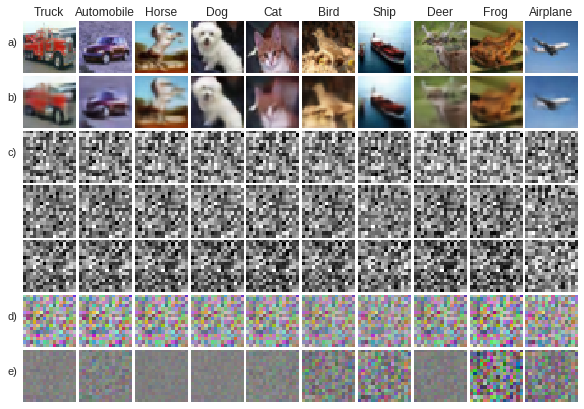

In [14]:
# Paths to data
DCSNNB1_PATH=DATA_PATH+"/Visualizations/D-CSNN-B1/Cifar10/xFoldCrossVal0"

mean_activities = np.load(DCSNNB1_PATH+"/test_mean_acts.npy")
sub_activities = np.load(DCSNNB1_PATH+"/test_sub_mean_acts.npy")
mean_activities = mean_activities+np.abs(np.min(mean_activities))
mean_activities = mean_activities/np.max(mean_activities)
sub_activities = sub_activities+np.abs(np.min(sub_activities))
sub_activities = sub_activities/np.max(sub_activities)

mean_differences_to_truck=mean_activities[9]-mean_activities
sort_indieces=np.argsort(np.sum(np.abs(mean_differences_to_truck), axis=(1,2,3)))


reconstructions = np.load(DCSNNB1_PATH+"/reconstructionCnn/Cifar10/reconstructions/test_recs.npy")
images = np.load(DCSNNB1_PATH+"/reconstructionCnn/Cifar10/reconstructions/test_images.npy")
labels = np.load(DCSNNB1_PATH+"/reconstructionCnn/Cifar10/reconstructions/test_labels.npy")

labelToName = {0:"Airplane", 1:"Automobile", 2:"Bird", 3:"Cat", 4:"Deer", 
               5:"Dog", 6:"Frog", 7:"Horse", 8:"Ship", 9:"Truck"}

# Class id sorted samples
image_indieces = np.array([543, 2535, 4982, 33, 4, 64, 111, 6, 777, 967])
image_indieces = image_indieces[sort_indieces]

reconstructions = reconstructions[image_indieces]
images = images[image_indieces]
labels = labels[image_indieces]

height = 7
width = len(image_indieces)
with plt.style.context('seaborn'):
    fig, axs = plt.subplots(height, width, figsize=(width*1.0, height*1.0))
    for h in range(0, height):
        for w in range(0, width):
            ax = axs[0,w]
            ax.imshow(images[w])
            ax.grid(False)
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            if w is 0:
                ax.set_ylabel('a)', rotation=0)    
            ax.set_title(labelToName[np.argmax(labels[w])]) 
        for w in range(0, width):
            ax = axs[1,w]
            ax.imshow(reconstructions[w])
            ax.grid(False)
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            if w is 0:
                ax.set_ylabel('b)', rotation=0)  
                
        for w in range(0, width):
            ax = axs[2,w]
            ax.imshow(mean_activities[np.argmax(labels[w]), :,:, 0])
            ax.grid(False)
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            if w is 0:
                ax.set_ylabel('c)', rotation=0)  
                
        for w in range(0, width):
            ax = axs[3,w]
            ax.imshow(mean_activities[np.argmax(labels[w]), :,:, 1])
            ax.grid(False)
            ax.set_yticklabels([])
            ax.set_xticklabels([])
                
        for w in range(0, width):
            ax = axs[4,w]
            ax.imshow(mean_activities[np.argmax(labels[w]), :,:, 2])
            ax.grid(False)
            ax.set_yticklabels([])
            ax.set_xticklabels([])

        for w in range(0, width):
            ax = axs[5,w]
            ax.imshow(mean_activities[np.argmax(labels[w])])
            ax.grid(False)
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            if w is 0:
                ax.set_ylabel('d)', rotation=0)  
                
        for w in range(0, width):
            ax = axs[6,w]
            if w == width-1:
                j = 0
            else:
                j = w+1
            ax.imshow(sub_activities[np.argmax(labels[w])][np.argmax(labels[j])])
            ax.grid(False)
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            if w is 0:
                ax.set_ylabel('e)', rotation=0)  

    
        plt.subplots_adjust(wspace=0.002, hspace=0.05)
    plt.savefig("recAndActs.pdf")
    plt.show()

## SOM Weight Images during training: Figure 9 of the Appendix from the Paper

Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one metagr

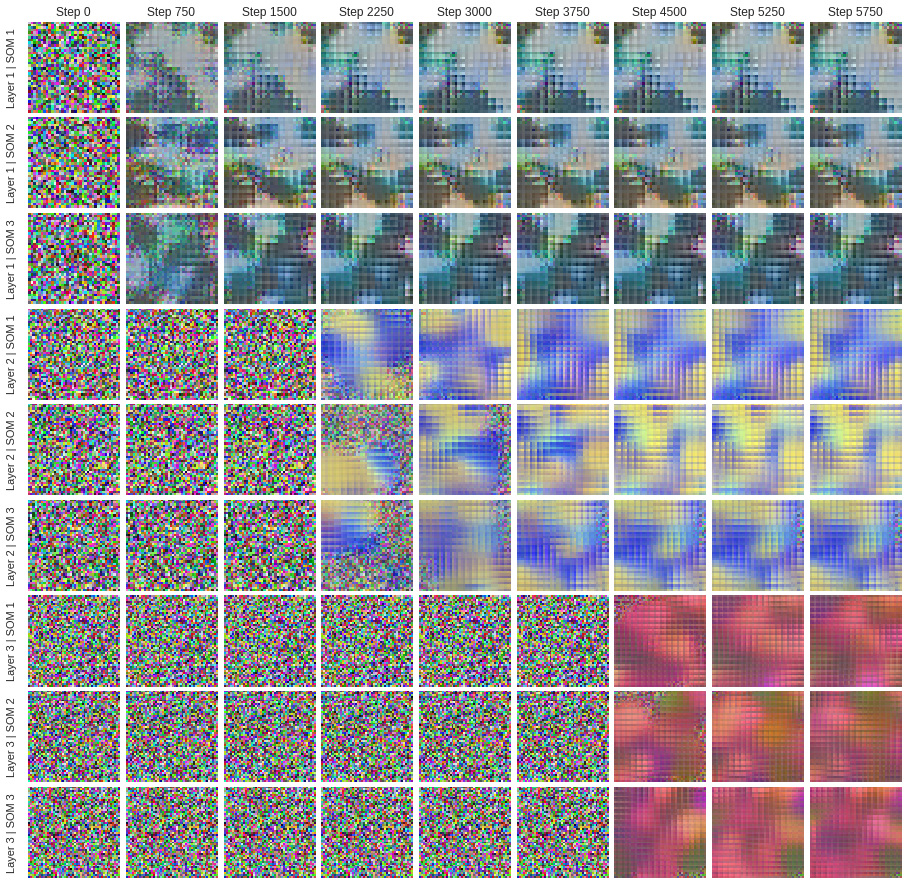

In [15]:
# Paths to data
DCSNNB1_PATH=DATA_PATH+"/MethodInfluences2/D-CSNN-B1/Cifar10/xFoldCrossVal0/Csnn/logs/train"

# Log image tags
i_tags=['Training/Csnn/Layer0/WeightGridForChannel_0__1__2_/image',
        'Training/Csnn/Layer0/WeightGridForChannel_0__1__2__1/image',
        'Training/Csnn/Layer0/WeightGridForChannel_0__1__2__2/image',
        'Training/Csnn/Layer1/WeightGridForChannel_0__1__2_/image',
        'Training/Csnn/Layer1/WeightGridForChannel_0__1__2__1/image',
        'Training/Csnn/Layer1/WeightGridForChannel_0__1__2__2/image',
        'Training/Csnn/Layer2/WeightGridForChannel_0__1__2_/image',
        'Training/Csnn/Layer2/WeightGridForChannel_0__1__2__1/image',
        'Training/Csnn/Layer2/WeightGridForChannel_0__1__2__2/image']

step_indices = [i for i in range(0, 24, 3)]
step_indices.append(-1)

saveAndShow2DImagePlotPerMap(i_tags, step_indices, 3, DCSNNB1_PATH, "somweights.pdf")

## BMU Images during training: Figure 10 of the Appendix from the Paper

Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one metagr

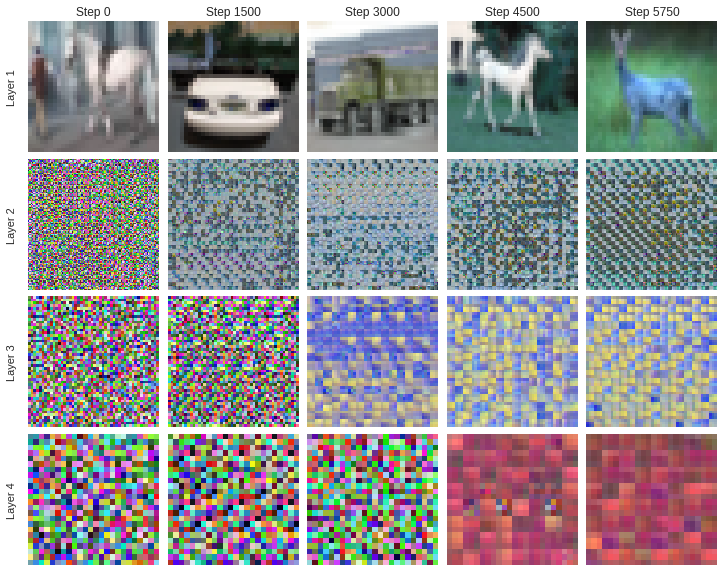

In [16]:
DCSNNB1_PATH=DATA_PATH+"/MethodInfluences2/D-CSNN-B1/Cifar10/xFoldCrossVal0/Csnn/logs/train"
i_tags=['Training/Csnn/Layer0/InputImage/image',
        'Training/Csnn/Layer0/WeightImgForMap0Channel_0__1__2_/image',
        'Training/Csnn/Layer1/WeightImgForMap0Channel_0__1__2_/image',
        'Training/Csnn/Layer2/WeightImgForMap0Channel_0__1__2_/image']

indices = [i for i in range(0, 24, 6)]
indices.append(-1)
saveAndShow2DImagePlot(i_tags, "Layer ", indices, DCSNNB1_PATH, "bmuimages.pdf")

## More BMU Images during training: Figure 11 and 12 of the Appendix from the Paper

Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one metagr

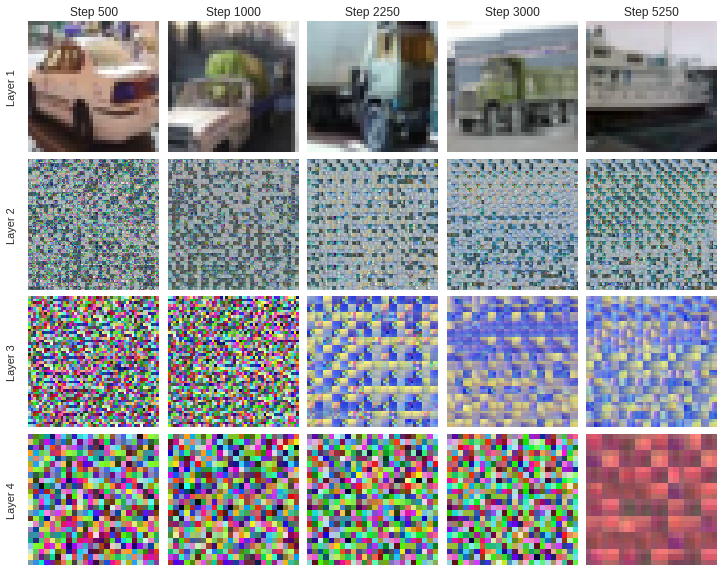

In [17]:
DCSNNB1_PATH=DATA_PATH+"/MethodInfluences2/D-CSNN-B1/Cifar10/xFoldCrossVal0/Csnn/logs/train"
i_tags=['Training/Csnn/Layer0/InputImage/image',
        'Training/Csnn/Layer0/WeightImgForMap0Channel_0__1__2_/image',
        'Training/Csnn/Layer1/WeightImgForMap0Channel_0__1__2_/image',
        'Training/Csnn/Layer2/WeightImgForMap0Channel_0__1__2_/image']

indices = [2,4,9,12,21]
saveAndShow2DImagePlot(i_tags, "Layer ", indices, DCSNNB1_PATH, "bmuimages2.pdf")

Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one metagr

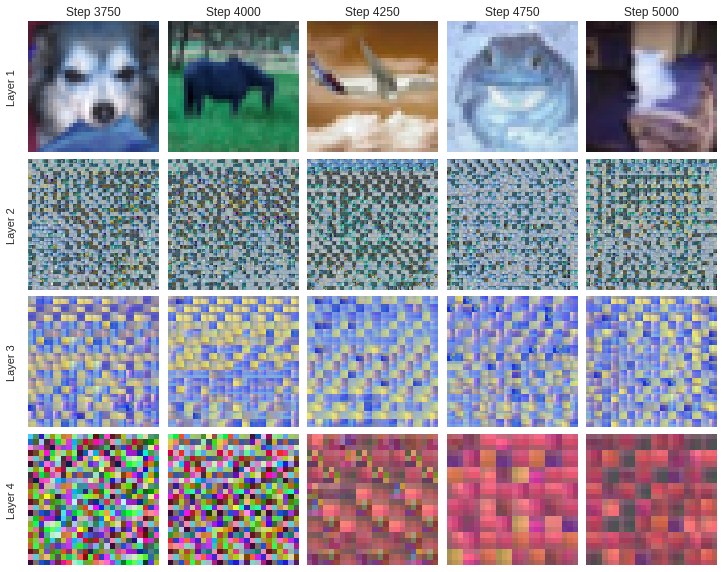

In [18]:
DCSNNB1_PATH=DATA_PATH+"/MethodInfluences2/D-CSNN-B1/Cifar10/xFoldCrossVal0/Csnn/logs/train"
i_tags=['Training/Csnn/Layer0/InputImage/image',
        'Training/Csnn/Layer0/WeightImgForMap0Channel_0__1__2_/image',
        'Training/Csnn/Layer1/WeightImgForMap0Channel_0__1__2_/image',
        'Training/Csnn/Layer2/WeightImgForMap0Channel_0__1__2_/image']

indices = [15,16,17,19,20]
saveAndShow2DImagePlot(i_tags, "Layer ", indices, DCSNNB1_PATH, "bmuimages3.pdf")

## Mask Value Images during training: Figure 13 of the Appendix from the Paper

Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one metagraph event per run. Overwriting the metagraph with the newest event.


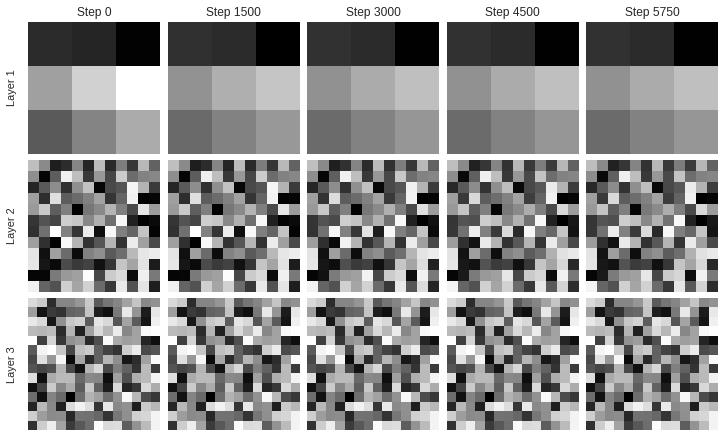

In [19]:
DCSNNB1_PATH=DATA_PATH+"/MethodInfluences2/D-CSNN-B1/Cifar10/xFoldCrossVal0/Csnn/logs/train"
i_tags=['Training/Csnn/Layer0/LocalWeightsMap0Neuron50PrevMap0/image',
        'Training/Csnn/Layer1/LocalWeightsMap0Neuron75PrevMap1/image',
        'Training/Csnn/Layer2/LocalWeightsMap0Neuron75PrevMap1/image']

indices = [i for i in range(0,24,6)]
indices.append(-1)
saveAndShow2DImagePlot(i_tags, "Layer ", indices, DCSNNB1_PATH, "masks.pdf")

## Neigborhood Coefficients Images during training: Figure 15 of the Appendix from the Paper

Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one metagr

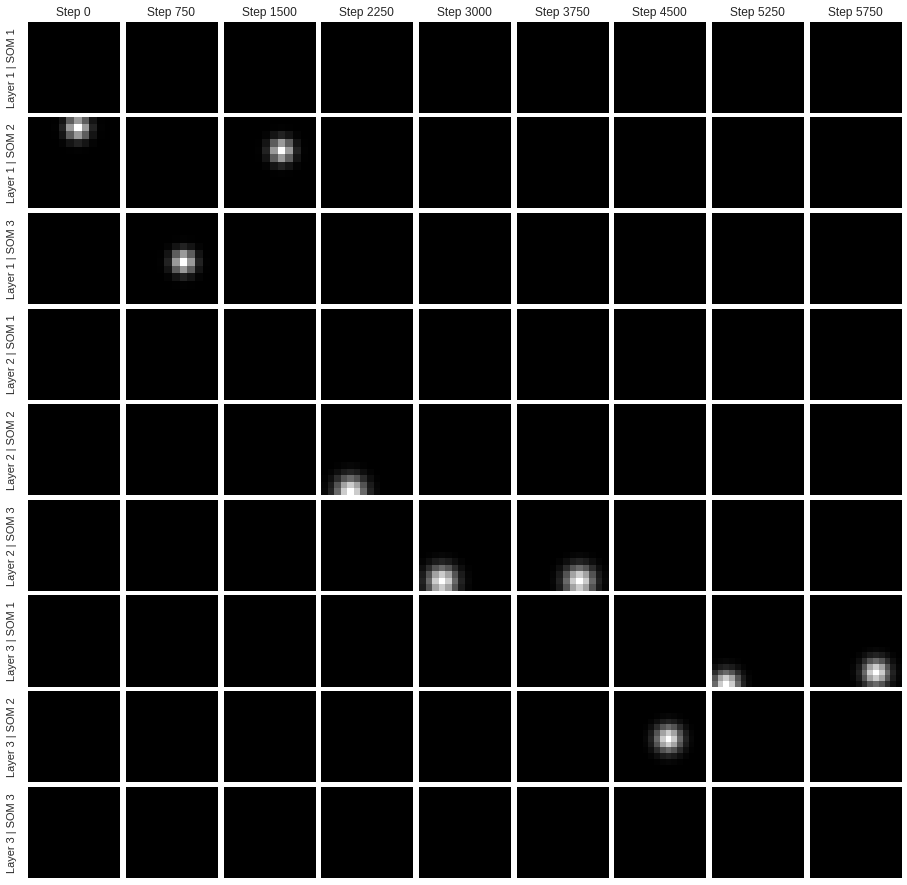

In [20]:
# Paths to data
DCSNNB1_PATH=DATA_PATH+"/MethodInfluences2/D-CSNN-B1/Cifar10/xFoldCrossVal0/Csnn/logs/train"

# Log image tags
i_tags=['Training/Csnn/Layer0/NeighborhoodAct_3__4_Map0/image',
        'Training/Csnn/Layer0/NeighborhoodAct_3__4_Map1/image',
        'Training/Csnn/Layer0/NeighborhoodAct_3__4_Map2/image',
        'Training/Csnn/Layer1/NeighborhoodAct_3__4_Map0/image',
        'Training/Csnn/Layer1/NeighborhoodAct_3__4_Map1/image',
        'Training/Csnn/Layer1/NeighborhoodAct_3__4_Map2/image',
        'Training/Csnn/Layer2/NeighborhoodAct_3__4_Map0/image',
        'Training/Csnn/Layer2/NeighborhoodAct_3__4_Map1/image',
        'Training/Csnn/Layer2/NeighborhoodAct_3__4_Map2/image']

step_indices = [i for i in range(0, 24, 3)]
step_indices.append(-1)

saveAndShow2DImagePlotPerMap(i_tags, step_indices, 3, DCSNNB1_PATH, "mapsCoeffs.pdf")

## Accuracy of the linear and nonlinear classifiers during training: Figure 16 of the Appendix from the Paper

Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one metagr

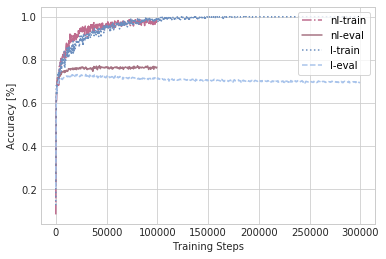

In [21]:
# Paths to data
DCSNNB1_PATH=DATA_PATH+"/MethodInfluences2/D-CSNN-B1/Cifar10/xFoldCrossVal0"

# Log tags
acc_tag="acc"

# Load the data
data = {"nl-train":loadTensorboardScalarData(acc_tag, DCSNNB1_PATH+"/nonlinearClassifier/logs/train"),
        "nl-eval":loadTensorboardScalarData(acc_tag, DCSNNB1_PATH+"/nonlinearClassifier/logs/eval"),
        "l-train":loadTensorboardScalarData(acc_tag, DCSNNB1_PATH+"/linearClassifier/logs/train"),
        "l-eval":loadTensorboardScalarData(acc_tag, DCSNNB1_PATH+"/linearClassifier/logs/eval")}

plotTrainingCurves(data, y_label="Accuracy [%]", save_name="accuracies.pdf")

## Loss of the linear and nonlinear classifiers during training: Figure 16 of the Appendix from the Paper

Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one metagr

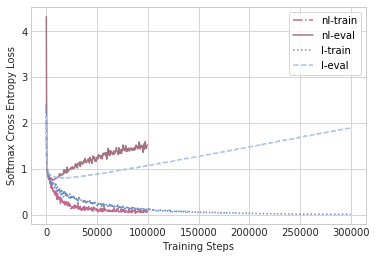

In [22]:
# Paths to data
DCSNNB1_PATH=DATA_PATH+"/MethodInfluences2/D-CSNN-B1/Cifar10/xFoldCrossVal0"

# Log tags
loss_tag="loss"

# Load the data
data = {"nl-train":loadTensorboardScalarData(loss_tag, DCSNNB1_PATH+"/nonlinearClassifier/logs/train"),
        "nl-eval":loadTensorboardScalarData(loss_tag, DCSNNB1_PATH+"/nonlinearClassifier/logs/eval"),
        "l-train":loadTensorboardScalarData(loss_tag, DCSNNB1_PATH+"/linearClassifier/logs/train"),
        "l-eval":loadTensorboardScalarData(loss_tag, DCSNNB1_PATH+"/linearClassifier/logs/eval")}

plotTrainingCurves(data, y_label="Softmax Cross Entropy Loss", save_name="loss.pdf")

## To get the accuracies to fill the tables call loadTableAccuraciesFromText()

In [23]:
loadTableAccuraciesFromText(DATA_PATH+"/Performances",
["D-CSNN-B1-Cifar10-Aug10Fold"], ["Cifar10", "Cifar100", "TinyImageNet", "SOMeImageNet"], ["linearClassifier", "nonlinearClassifier", "fewShotClassifier50Shot"])

D-CSNN-B1-Cifar10-Aug10Fold Cifar10 linearClassifier Max acc:75.68 Min acc:72.57 Mean acc:73.73 + acc:1.95 - acc:-1.17
D-CSNN-B1-Cifar10-Aug10Fold Cifar10 nonlinearClassifier Max acc:81.55 Min acc:78.99 Mean acc:80.03 + acc:1.52 - acc:-1.05


{'Cifar10': {'D-CSNN-B1-Cifar10-Aug10Fold': {'linearClassifier': [73.98875951766968,
    74.22193884849548,
    73.19754362106323,
    73.84167909622192,
    73.18997383117676,
    72.56616353988647,
    74.24107193946838,
    73.26490879058838,
    75.68359375,
    73.11623096466064],
   'nonlinearClassifier': [79.3714165687561,
    79.83736991882324,
    79.62093353271484,
    80.20368814468384,
    79.64365482330322,
    78.9851725101471,
    81.14676475524902,
    79.82820272445679,
    81.55412673950195,
    80.13752102851868]}}}